In [1]:
# Cell 1: Install & authenticate (only needed once ever)
!pip install -q earthengine-api --upgrade


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import ee
ee.Authenticate()           #  log in with your Google account
ee.Initialize()
print("Google Earth Engine ready!")

Google Earth Engine ready!


In [3]:
# Uganda region
roi = ee.Geometry.Rectangle([29.5, -1.5, 35.0, 4.25])   

if roi is None:
    print("Exporting GLOBAL data")
else:
    print("Exporting your chosen region")

Exporting your chosen region


In [7]:
# CELL 3 – Load monthly ERA5-Land aggregated data
dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR') \
            .filterDate('1961-01-01', '2025-01-01')

print(f"Found {dataset.size().getInfo()} monthly images → should be 768")

Found 768 monthly images → should be 768


In [8]:
# CELL 4 – Convert to multi-band image (SERVER-SIDE ONLY!)
def rename_monthly(image):
    # Get date server-side
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')
    month = date.get('month').format('%02d')
    yrmo = date.format('YYYY_MM')
    
    # Rename bands using server-side strings
    tmax = image.select('temperature_2m_max') \
                .rename(ee.String('tmax_').cat(yrmo))
    tmin = image.select('temperature_2m_min') \
                .rename(ee.String('tmin_').cat(yrmo))
    
    return tmax.addBands(tmin)

monthly_multi_band = dataset.map(rename_monthly).toBands()
print("Conversion done – ready to export")

Conversion done – ready to export


In [9]:
# CELL 5 – Export to Google Drive (takes 3–6 minutes for Uganda)
task = ee.batch.Export.image.toDrive(
    image=monthly_multi_band.toFloat(),
    description='ERA5Land_Uganda_monthly_tmax_tmin_1961_2024',
    folder='EarthEngine_Exports',
    fileNamePrefix='ERA5Land_Uganda_monthly_tmax_tmin_1961_2024',
    region=roi,
    scale=11132,                    # ~0.1° native resolution
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True}
)

task.start()
print("EXPORT STARTED!")
print("Check progress → https://code.earthengine.google.com/tasks")
print("File will appear in your Google Drive in 3–6 minutes (~70 MB)")

EXPORT STARTED!
Check progress → https://code.earthengine.google.com/tasks
File will appear in your Google Drive in 3–6 minutes (~70 MB)


PERFECT FILE SAVED → ERA5Land_Uganda_monthly_1961_2024_FINAL.nc


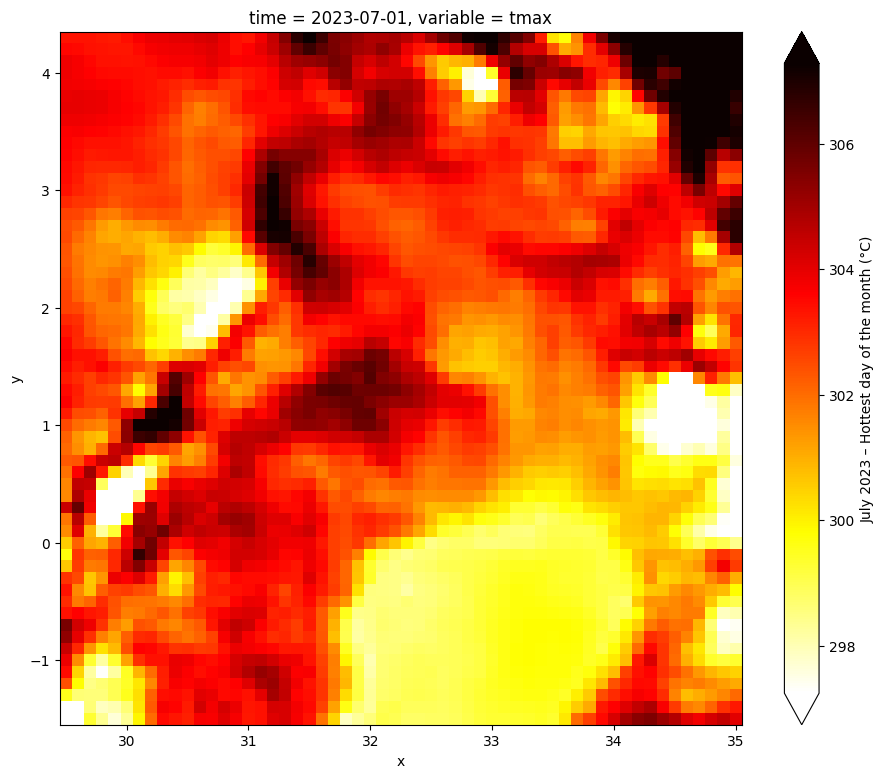

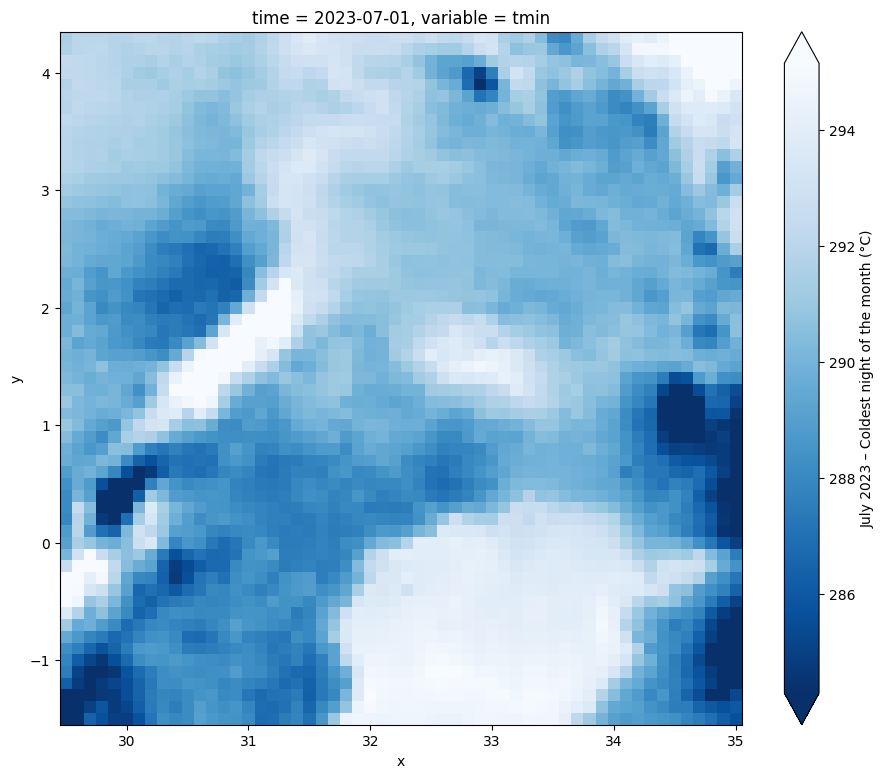

In [19]:
import xarray as xr
import pandas as pd
import numpy as np

# 1. Open the raster file
ds = xr.open_dataset('ERA5Land_Uganda_monthly_tmax_tmin_1961_2024.tif', engine='rasterio')

# Extract raw array: shape = (1536, y, x)
data = ds.band_data.values

# 2. Create time and variable coordinates
months = pd.date_range('1961-01-01', '2024-12-01', freq='MS')  # 768 months
variables = ['tmax', 'tmin']

# 3. Reshape the array → (time=768, variable=2, y, x)
data_reshaped = data.reshape(len(months), 2, data.shape[1], data.shape[2])

# 4. Build clean dataset with proper dimensions
ds_clean = xr.DataArray(
    data_reshaped,
    dims=['time', 'variable', 'y', 'x'],
    coords={
        'time': months,
        'variable': variables,
        'y': ds.y,
        'x': ds.x
    },
    name='temperature'
).to_dataset()

# 5. NOW selection works!
ds_clean.sel(time='2023-07-01', variable='tmax').temperature.plot(
    cmap='hot_r', robust=True, figsize=(11,9),
    cbar_kwargs={'label': 'July 2023 – Hottest day of the month (°C)'}
)

ds_clean.sel(time='2023-07-01', variable='tmin').temperature.plot(
    cmap='Blues_r', robust=True, figsize=(11,9),
    cbar_kwargs={'label': 'July 2023 – Coldest night of the month (°C)'}
)

# 6. Save the perfect file
ds_clean.to_netcdf('ERA5Land_Uganda_monthly_1961_2024_FINAL.nc')
print("PERFECT FILE SAVED → ERA5Land_Uganda_monthly_1961_2024_FINAL.nc")


In [20]:
# Load your finalized dataset with structure:
# temperature(time, variable, y, x)
ds = xr.open_dataset("ERA5Land_Uganda_monthly_1961_2024_FINAL.nc")

ds


<xarray.Dataset> Size: 20MB
Dimensions:      (time: 768, variable: 2, y: 59, x: 56)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1961-01-01 1961-02-01 ... 2024-12-01
  * variable     (variable) <U4 32B 'tmax' 'tmin'
  * y            (y) float64 472B 4.3 4.2 4.1 4.0 3.9 ... -1.2 -1.3 -1.4 -1.5
  * x            (x) float64 448B 29.5 29.6 29.7 29.8 ... 34.7 34.8 34.9 35.0
Data variables:
    temperature  (time, variable, y, x) float32 20MB ...

In [21]:
# Monthly average temperature = (tmax + tmin) / 2
monthly_tavg = ds.temperature.mean(dim="variable")
monthly_tavg


<xarray.DataArray 'temperature' (time: 768, y: 59, x: 56)> Size: 10MB
array([[[299.68655, 299.79593, 299.79898, ..., 303.2679 , 303.57846,
         303.05795],
        [299.6221 , 299.64957, 299.7443 , ..., 302.9525 , 303.23944,
         303.06088],
        [299.78616, 299.70718, 299.6984 , ..., 302.3529 , 302.79706,
         302.9896 ],
        ...,
        [289.94537, 288.87494, 289.3515 , ..., 294.3844 , 294.22815,
         294.9137 ],
        [286.00854, 287.44818, 289.62885, ..., 295.41467, 295.18518,
         295.29358],
        [284.7088 , 288.31927, 290.91864, ..., 296.62463, 296.44983,
         296.15002]],

       [[298.98428, 299.14178, 299.14764, ..., 302.5741 , 302.95667,
         302.66718],
        [299.1334 , 299.24503, 299.27167, ..., 302.251  , 302.60678,
         302.4688 ],
        [299.39413, 299.3651 , 299.37012, ..., 301.8812 , 302.21323,
         302.23764],
...
        [291.05267, 290.53296, 290.63647, ..., 293.94034, 294.01572,
         294.57794],
        [287.26013, 288.91492, 291.24292, ..., 294.91498, 294.99603,
         295.0973 ],
        [286.10913, 289.44702, 292.09854, ..., 296.01837, 296.06195,
         295.8335 ]],

       [[299.9826 , 300.26385, 300.1281 , ..., 301.53363, 301.72015,
         301.33752],
        [300.0839 , 300.24557, 300.13815, ..., 301.45862, 301.55627,
         301.33948],
        [300.48526, 300.33878, 300.18503, ..., 301.34338, 301.5197 ,
         301.53226],
        ...,
        [290.57666, 289.94293, 290.18082, ..., 292.05887, 292.02512,
         292.64914],
        [286.7072 , 288.47086, 291.09293, ..., 293.09598, 293.11496,
         293.40305],
        [285.7209 , 289.31708, 292.2624 , ..., 294.35086, 294.3513 ,
         293.8386 ]]], shape=(768, 59, 56), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1961-01-01 1961-02-01 ... 2024-12-01
  * y        (y) float64 472B 4.3 4.2 4.1 4.0 3.9 ... -1.1 -1.2 -1.3 -1.4 -1.5
  * x        (x) float64 448B 29.5 29.6 29.7 29.8 29.9 ... 34.7 34.8 34.9 35.0

In [22]:
yearly_tmax = (
    ds.temperature
    .sel(variable="tmax")
    .groupby("time.year")
    .mean(dim="time")
)
yearly_tmax


<xarray.DataArray 'temperature' (year: 64, y: 59, x: 56)> Size: 846kB
array([[[304.3101 , 304.41537, 304.38644, ..., 308.494  , 308.83627,
         308.407  ],
        [304.43954, 304.4808 , 304.4603 , ..., 308.27472, 308.60526,
         308.3482 ],
        [304.68597, 304.63007, 304.51813, ..., 308.22446, 308.60437,
         308.62906],
        ...,
        [296.02347, 294.70932, 294.89963, ..., 299.68484, 299.91467,
         300.1381 ],
        [291.79883, 293.14514, 295.1567 , ..., 300.5382 , 301.12253,
         301.32285],
        [290.51   , 294.01736, 296.7457 , ..., 302.59366, 302.7645 ,
         302.3832 ]],

       [[303.594  , 303.70615, 303.71643, ..., 308.7982 , 309.08325,
         308.6177 ],
        [303.71448, 303.8007 , 303.80875, ..., 308.6205 , 308.8661 ,
         308.551  ],
        [304.0217 , 303.97253, 303.8964 , ..., 308.57648, 308.8491 ,
         308.82822],
...
        [297.81943, 296.9329 , 296.7739 , ..., 301.73898, 302.11377,
         302.47806],
        [293.35706, 294.84552, 297.30597, ..., 302.4733 , 303.30103,
         303.652  ],
        [292.05154, 295.42368, 298.3126 , ..., 304.568  , 304.8453 ,
         304.43402]],

       [[306.6375 , 306.75253, 306.78687, ..., 311.02072, 311.23987,
         310.7748 ],
        [306.79907, 306.84583, 306.81216, ..., 310.91135, 311.03955,
         310.67746],
        [307.1252 , 307.0494 , 306.89975, ..., 310.88885, 311.02502,
         310.89502],
        ...,
        [298.0569 , 297.16055, 296.98825, ..., 300.72995, 300.8827 ,
         301.23062],
        [293.56274, 295.12778, 297.62753, ..., 301.60965, 302.19376,
         302.54764],
        [292.28897, 295.69882, 298.65158, ..., 303.71835, 303.91086,
         303.43   ]]], shape=(64, 59, 56), dtype=float32)
Coordinates:
  * year      (year) int64 512B 1961 1962 1963 1964 1965 ... 2021 2022 2023 2024
  * y         (y) float64 472B 4.3 4.2 4.1 4.0 3.9 ... -1.1 -1.2 -1.3 -1.4 -1.5
  * x         (x) float64 448B 29.5 29.6 29.7 29.8 29.9 ... 34.7 34.8 34.9 35.0
    variable  <U4 16B 'tmax'

In [23]:
yearly_tmin = (
    ds.temperature
    .sel(variable="tmin")
    .groupby("time.year")
    .mean(dim="time")
)
yearly_tmin


<xarray.DataArray 'temperature' (year: 64, y: 59, x: 56)> Size: 846kB
array([[[291.23212, 291.44952, 291.42795, ..., 294.0213 , 294.2935 ,
         294.1215 ],
        [291.2927 , 291.39432, 291.40915, ..., 293.7389 , 293.94077,
         293.9349 ],
        [291.5496 , 291.50677, 291.44907, ..., 293.3073 , 293.58344,
         293.70126],
        ...,
        [284.18762, 283.5384 , 284.21   , ..., 285.22427, 284.96872,
         285.67502],
        [280.38278, 282.10623, 284.59738, ..., 286.0839 , 285.92685,
         285.82983],
        [279.2377 , 283.077  , 285.88782, ..., 286.76593, 286.5546 ,
         286.17545]],

       [[291.07986, 291.34003, 291.35025, ..., 293.85117, 294.16318,
         294.01862],
        [291.14545, 291.34238, 291.3835 , ..., 293.72946, 293.9598 ,
         293.9288 ],
        [291.43512, 291.41568, 291.40952, ..., 293.5653 , 293.6902 ,
         293.81656],
...
        [285.25485, 284.8924 , 285.18076, ..., 286.08725, 285.89526,
         286.85846],
        [281.56876, 283.15347, 285.71396, ..., 287.31448, 287.0054 ,
         287.12408],
        [280.5502 , 283.85345, 286.64453, ..., 287.92282, 287.6068 ,
         287.2561 ]],

       [[293.0053 , 293.28683, 293.25357, ..., 295.96344, 296.14114,
         295.83475],
        [292.97382, 293.17133, 293.15222, ..., 295.74512, 295.8365 ,
         295.66275],
        [293.2176 , 293.1746 , 293.11884, ..., 295.5217 , 295.57047,
         295.55292],
        ...,
        [285.67996, 285.2806 , 285.54324, ..., 285.92056, 285.84558,
         286.57312],
        [281.841  , 283.58694, 286.17612, ..., 287.01132, 286.75516,
         286.7335 ],
        [280.88763, 284.34427, 287.07678, ..., 287.60074, 287.2234 ,
         286.84436]]], shape=(64, 59, 56), dtype=float32)
Coordinates:
  * year      (year) int64 512B 1961 1962 1963 1964 1965 ... 2021 2022 2023 2024
  * y         (y) float64 472B 4.3 4.2 4.1 4.0 3.9 ... -1.1 -1.2 -1.3 -1.4 -1.5
  * x         (x) float64 448B 29.5 29.6 29.7 29.8 29.9 ... 34.7 34.8 34.9 35.0
    variable  <U4 16B 'tmin'

In [24]:
yearly_tavg = (
    monthly_tavg
    .groupby("time.year")
    .mean(dim="time")
)
yearly_tavg


<xarray.DataArray 'temperature' (year: 64, y: 59, x: 56)> Size: 846kB
array([[[297.77112, 297.93246, 297.90723, ..., 301.25766, 301.5649 ,
         301.26425],
        [297.86612, 297.93753, 297.93472, ..., 301.00684, 301.27304,
         301.14157],
        [298.11777, 298.06842, 297.9836 , ..., 300.7659 , 301.0939 ,
         301.16516],
        ...,
        [290.10556, 289.12387, 289.55484, ..., 292.45453, 292.44165,
         292.90652],
        [286.0908 , 287.62567, 289.87704, ..., 293.31107, 293.5247 ,
         293.57632],
        [284.87384, 288.54718, 291.31674, ..., 294.67978, 294.65955,
         294.2793 ]],

       [[297.33694, 297.5231 , 297.53333, ..., 301.32468, 301.62323,
         301.3182 ],
        [297.4299 , 297.57153, 297.59613, ..., 301.17502, 301.41296,
         301.2399 ],
        [297.7284 , 297.69406, 297.65298, ..., 301.0709 , 301.26968,
         301.3224 ],
...
        [291.5371 , 290.91263, 290.9773 , ..., 293.91312, 294.0045 ,
         294.66827],
        [287.46292, 288.99948, 291.50998, ..., 294.8939 , 295.15323,
         295.38803],
        [286.30087, 289.63855, 292.47855, ..., 296.24542, 296.22607,
         295.84506]],

       [[299.8214 , 300.01968, 300.0202 , ..., 303.4921 , 303.69052,
         303.30472],
        [299.88647, 300.00858, 299.9822 , ..., 303.32825, 303.43802,
         303.17014],
        [300.17142, 300.112  , 300.00928, ..., 303.2053 , 303.29776,
         303.22397],
        ...,
        [291.86844, 291.22055, 291.26578, ..., 293.32523, 293.3641 ,
         293.90182],
        [287.70187, 289.35736, 291.90182, ..., 294.31052, 294.47446,
         294.64056],
        [286.58832, 290.02158, 292.8642 , ..., 295.65952, 295.5671 ,
         295.13718]]], shape=(64, 59, 56), dtype=float32)
Coordinates:
  * year     (year) int64 512B 1961 1962 1963 1964 1965 ... 2021 2022 2023 2024
  * y        (y) float64 472B 4.3 4.2 4.1 4.0 3.9 ... -1.1 -1.2 -1.3 -1.4 -1.5
  * x        (x) float64 448B 29.5 29.6 29.7 29.8 29.9 ... 34.7 34.8 34.9 35.0

In [25]:
# Spatially averaged yearly temperatures
yearly_tmax_avg = yearly_tmax.mean(dim=("y","x"))
yearly_tmin_avg = yearly_tmin.mean(dim=("y","x"))
yearly_tavg_avg = yearly_tavg.mean(dim=("y","x"))


In [26]:
# Convert to Pandas DataFrame
df = pd.DataFrame({
    "year": yearly_tavg_avg.year.values,
    "tmax_C": yearly_tmax_avg.values,
    "tmin_C": yearly_tmin_avg.values,
    "mean_temp_C": yearly_tavg_avg.values
})

df.head()


,year,tmax_C,tmin_C,mean_temp_C
0,1961,301.176758,289.556213,295.366486
1,1962,300.793915,289.325775,295.059845
2,1963,300.592529,289.328094,294.960327
3,1964,300.940735,289.421906,295.181305
4,1965,301.756653,289.579407,295.668060


In [28]:
output_csv = "Uganda_ERA5Land_yearly_mean_temperatures_1961_2024.csv"
df.to_csv(output_csv, index=False)

print("CSV GENERATED →", output_csv)


CSV GENERATED → Uganda_ERA5Land_yearly_mean_temperatures_1961_2024.csv


In [30]:
ds["temperature_celsius"] = ds["temperature"] - 273.15


In [31]:
yearly_mean_celsius = ds["temperature_celsius"].groupby("time.year").mean("time")


In [32]:
df = yearly_mean_celsius.to_dataframe().reset_index()
df.to_csv("yearly_avg_temperature_celsius.csv", index=False)


In [36]:
import xarray as xr
import pandas as pd

# Load the cleaned dataset
ds = xr.open_dataset("ERA5Land_Uganda_monthly_1961_2024_FINAL.nc")

# Convert Kelvin → Celsius
ds["temperature_celsius"] = ds["temperature"] - 273.15

# Select tmax and tmin along the variable dimension
tmax = ds["temperature_celsius"].sel(variable="tmax")
tmin = ds["temperature_celsius"].sel(variable="tmin")

# Spatial mean (average over y,x)
tmax_spatial = tmax.mean(dim=["y", "x"])
tmin_spatial = tmin.mean(dim=["y", "x"])

#  Compute monthly mean temperature = (tmax + tmin)/2
tmean_monthly = (tmax_spatial + tmin_spatial) / 2

# Group by year and compute yearly mean
tmean_yearly = tmean_monthly.groupby("time.year").mean()

#  Convert to DataFrame
df = tmean_yearly.to_dataframe(name="annual_avg_temp_celsius").reset_index()

#  Save CSV
df.to_csv("Uganda_yearly_mean_tmax_tmin_1961_2024.csv", index=False)

print("DONE → Uganda_yearly_mean_tmax_tmin_1961_2024.csv created successfully!")


DONE → Uganda_yearly_mean_tmax_tmin_1961_2024.csv created successfully!
